In [1]:
# These are the Python imports that we use in this Qiskit-based example

from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RGQFTMultiplier
import numpy as np

from pathlib import Path
import sys
BASE_PATH = str(Path.cwd().parent.parent)
sys.path.append(BASE_PATH)
from aquapointer.digital.ansatz import QAOA_ansatz

In [2]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.density_canvas.Lattice import Lattice
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.primitives import BackendSampler
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

def get_qubo_coeffs(canvas):
    estimated_variance = 30
    estimated_amplitude = 10

    # canvas.set_poisson_disk_lattice(spacing=(5, 5))
    canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)
    _ = canvas.calculate_pubo_coefficients(
            p = 2, #order of the PUBO, p=2 effectively creates a QUBO
            params = [estimated_amplitude, estimated_variance],
            efficient_qubo=True
        )
    qubo_coeffs = canvas._pubo

    return qubo_coeffs


# from the qubo coefficients dictionary, create a qubo matrix:
def get_random_qubo(size, seed):
    # define a canvas
    origin = (-20, -20)
    length = 40
    npoints = 80
    canvas = DensityCanvas(
        origin=origin,
        length_x=length,
        length_y=length,
        npoints_x=npoints,
        npoints_y=npoints,
    )
    # extract random centers with a minimal distance
    # and a padding from border
    n_centers = size #number of Gaussians
    min_dist = 1 #minimal distance between gaussians
    padding = 6 #minimal distance of Gaussian centers from border
    amplitude = 10 #amplitude of the Gaussians
    variance = 30 #variance of the Gaussians

    canvas.set_randomized_gaussian_density(
        n_centers = n_centers,
        amplitude = amplitude,
        variance = variance,
        minimal_distance = min_dist,
        padding = padding,
        seed=seed
    )
    # To see the result, call the draw method with draw_centers=True
    # canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

    qubo = get_qubo_coeffs(canvas)
    
    qubo_matrix = np.zeros((len(qubo['coeffs'][1]), len(qubo['coeffs'][1])))

    for key in qubo['coeffs'][1].keys():
        qubo_matrix[key[0]][key[0]] = qubo['coeffs'][1][key]

    for key in qubo['coeffs'][2].keys():
        qubo_matrix[key] = qubo['coeffs'][2][key]
        qubo_matrix[key[::-1]] = qubo['coeffs'][2][key]

    return qubo_matrix


In [8]:
def create_algorithm(qubo, backend):

    qaoa_ansatz = QAOA_ansatz(qubo=qubo).qaoa_ansatz

    beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
    gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
    params = np.array(beta+gamma)

    qaoa_ansatz.assign_parameters(parameters=params, inplace=True)

    circ = qaoa_ansatz

    # retrieve basis gates from backend
    basis_gates = backend.configuration().basis_gates
    circ = transpile(circ, basis_gates=basis_gates, optimization_level=0)
    
    return circ


In [9]:
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

workspace = Workspace(
            resource_id = "",
            location = "")


provider = AzureQuantumProvider(workspace)


In [10]:
backend = provider.get_backend('microsoft.estimator')


Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


Next we will create an instance of our algorithm using the `create_algorithm` function. You can adjust the size of the multiplier by changing the `bitwidth` variable.

In [11]:
circ = create_algorithm(qubo, backend)


In [12]:
job = backend.run(circ)
result = job.result()


.......

In [13]:
result


Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 230 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.41M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 9.66e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,158.51k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 154,880 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,230,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,230,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 230. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,280,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 20 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,16,"Number of T factories capable of producing the demanded 280 T states during the algorithm's runtime The total number of T factories 16 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{280 \cdot 57,200\;\text{ns}}{1 \cdot 1,012,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,18,"Number of times all T factories are invoked In order to prepare the 280 T states, the 16 copies of the T factory are repeatedly invoked 18 times."
Physical algorithmic qubits,3.63k,"Number of physical qubits for the algorithm after layout The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


The total error budget sets the overall allowed error for the algorithm, i.e., the number of times it is allowed to fail. Its value must be between 0 and 1 and the default value is 0.001, which corresponds to 0.1%, and means that the algorithm is allowed to fail once in 1000 executions. This parameter is highly application specific. For example, if one is running Shor's algorithm for factoring integers, a large value for the error budget may be tolerated as one can check that the output are indeed the prime factors of the input. On the other hand, a much smaller error budget may be needed for an algorithm solving a problem with a solution which cannot be efficiently verified. This budget $\epsilon = \epsilon_{\log} + \epsilon_{\rm dis} + \epsilon_{\rm syn}$ is uniformly distributed and applies to errors $\epsilon_{\log}$ to implement logical qubits, an error budget $\epsilon_{\rm dis}$ to produce T states through distillation, and an error budget $\epsilon_{\rm syn}$ to synthesize rotation gates with arbitrary angles. Note that for distillation and rotation synthesis, the respective error budgets $\epsilon_{\rm dis}$ and $\epsilon_{\rm syn}$ are uniformly distributed among all T states and all rotation gates, respectively. If there are no rotation gates in the input algorithm, the error budget is uniformly distributed to logical errors and T state errors.


The code distance is the smallest odd integer greater or equal to $\dfrac{2\log(0.03 / 0.000000015360983102918585)}{\log(0.01/0.001)} - 1$ (Required logical qubit error rate in denominator)


The code distance is the smallest odd integer greater or equal to $\dfrac{2\log(0.03 / 0.0000000966183574879227)}{\log(0.01/0.001)} - 1$

Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits.

The logical qubit error rate is computed as $0.03 \cdot \left(\dfrac{0.001}{0.01}\right)^\frac{11 + 1}{2}$

The distribution of physical qubits used for the execution of the algorithm instructions and the supporting T factories can provide us valuable information to guide us in applying space and time optimizations. We can visualize this distribution to better understand the estimated space requirements for our algorithm.

In [14]:
result.data()['logicalQubit']['codeDistance']#['physicalCounts']

11

In [15]:
import matplotlib.pyplot as plt
np.random.seed(42)

def get_depth(circ):
    depth = circ.depth()
    return depth
    
def get_runtime(circ):
    job = backend.run(circ)
    result = job.result()
    runtime = result.data()['physicalCounts']['runtime']
    qubit = result.data()['physicalCounts']['physicalQubits']
    distance = result.data()['logicalQubit']['codeDistance']
    return runtime, qubit, distance


sizes = range(4, 50)

mean_distances = []
std_distances = []
mean_qubits = []
std_qubits = []
mean_depths = []
std_depths = []
mean_runtimes = []
std_runtimes = []

num_trials = 5

for size in sizes:
    print(size)
    distances = []
    qubits = []
    depths = []
    runtimes = []
    for _ in range(num_trials):
        seed = np.random.randint(1,10000)
        qubo_matrix = get_random_qubo(size, seed)
        circ = create_algorithm(qubo_matrix, backend)
        depth = get_depth(circ)
        runtime, qubit, distance = get_runtime(circ)
        
        distances.append(distance)
        qubits.append(qubit)
        depths.append(depth)
        runtimes.append(runtime)
    
    mean_distances.append(np.mean(distances))
    std_distances.append(np.std(distances))
    mean_qubits.append(np.mean(qubits))
    std_qubits.append(np.std(qubits))
    mean_depths.append(np.mean(depths))
    std_depths.append(np.std(depths))
    mean_runtimes.append(np.mean(runtimes))
    std_runtimes.append(np.std(runtimes))

# rescale to millisecs
mean_runtimes = np.array(mean_runtimes)
mean_runtimes = mean_runtimes/10**7 
std_runtimes = np.array(std_runtimes)
std_runtimes = std_runtimes/10**7




4
.............................5
.........................6
..........................7
.............................8
...........................9
.............................10
..........................11
............................12
...........................13
...........................14
...........................15
..........................16
...........................17
............................18
.............................19
...........................20
..........................21
...........................22
.............................23
...........................24
..........................25
............................26
............................27
..........................28
..............................29
...........................30
............................31
.............................32
............................33
...........................34
..............................35
..............................36
........................

## Figure 3

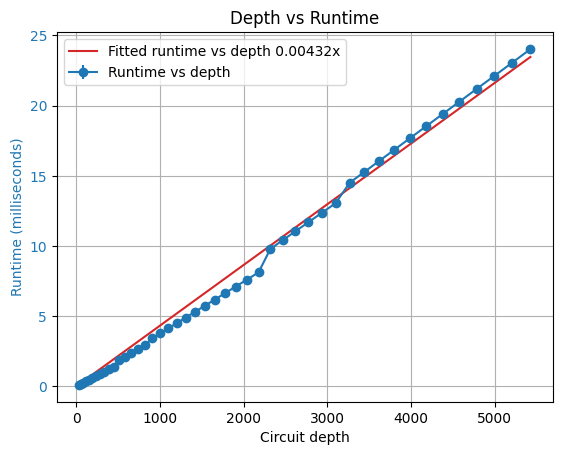

In [26]:
from scipy.optimize import curve_fit
def polynomial_model(x, a):
    return a * np.power(x, 1)


# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(polynomial_model, list(mean_depths), mean_runtimes)
a = popt[0]

fitted_runtimes = polynomial_model(np.array(mean_depths), a)

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Circuit depth')
ax1.set_ylabel('Runtime (milliseconds)', color=color)
ax1.errorbar(mean_depths, mean_runtimes,xerr=std_depths, yerr=std_runtimes, fmt='-o', color=color, label='Runtime vs depth')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(mean_depths, fitted_runtimes, color='tab:red', label=f'Fitted runtime vs depth {round(a,5)}x')
# ax1.set_yscale('log')
# ax2.set_yscale('log')
plt.legend()
# fig.tight_layout()
plt.title('Depth vs Runtime')
# plt.tight_layout()
plt.grid()
plt.savefig('runtime_vs_depth.pdf')
plt.show()

## Figure 2

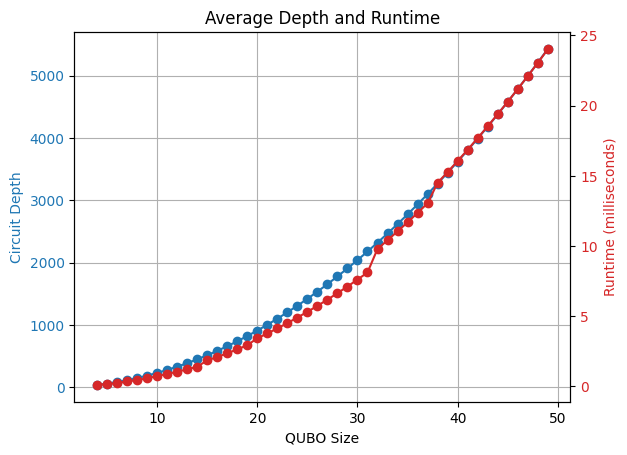

In [27]:
# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Circuit Depth', color=color)
ax1.errorbar(sizes, mean_depths, yerr=std_depths, fmt='-o', color=color, label='Depth')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Runtime (milliseconds)', color=color)
ax2.errorbar(sizes, mean_runtimes, yerr=std_runtimes, fmt='-o', color=color, label='Runtime')
ax2.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
# ax2.set_yscale('log')

# fig.tight_layout()
plt.title('Average Depth and Runtime')
# plt.tight_layout()
ax1.grid()
plt.savefig('runtime_depth.pdf')
plt.show()

## Figure 4

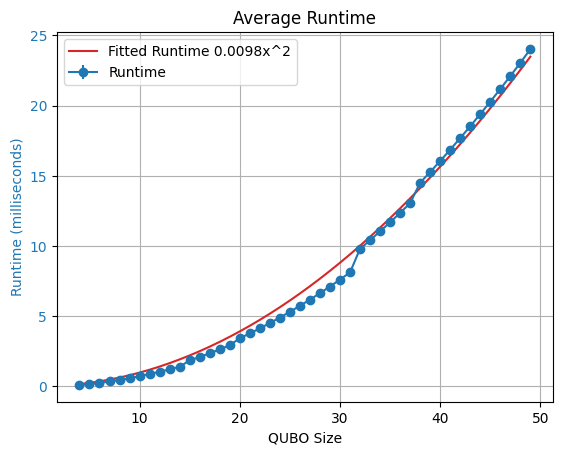

In [24]:
from scipy.optimize import curve_fit
def polynomial_model(x, a):
    return a * np.power(x, 2)


# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(polynomial_model, list(sizes), mean_runtimes)
a = popt[0]
b=2
# Generate fitted data for the polynomial model
sizes_fit = list(range(4, 50))
fitted_runtimes = polynomial_model(np.array(sizes_fit), a)

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Runtime (milliseconds)', color=color)
ax1.errorbar(sizes, mean_runtimes, yerr=std_runtimes, fmt='-o', color=color, label='Runtime')
ax1.plot(sizes_fit, fitted_runtimes, color='tab:red', label=f'Fitted Runtime {round(a,4)}x^{round(b,4)}')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
plt.legend()

# fig.tight_layout()
plt.title('Average Runtime')
# plt.tight_layout()
plt.grid()
plt.savefig('fit_runtime.pdf')
plt.show()

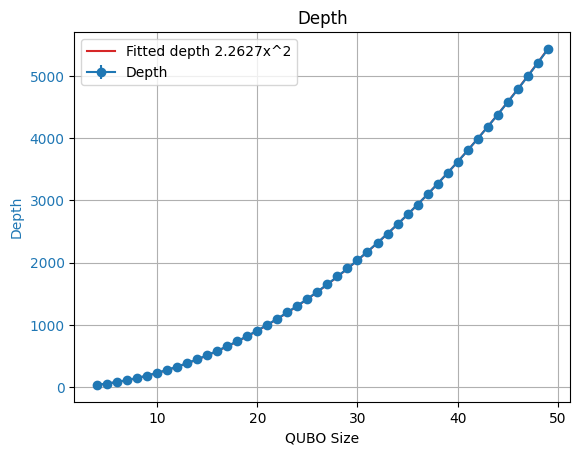

In [21]:
from scipy.optimize import curve_fit
def polynomial_model(x, a):
    return a * np.power(x, 2)


# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(polynomial_model, list(sizes), mean_depths)
a = popt[0]
b=2
# Generate fitted data for the polynomial model
sizes_fit = list(range(4, 50))
fitted_depths = polynomial_model(np.array(sizes_fit), a)

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Depth', color=color)
ax1.errorbar(sizes, mean_depths, yerr=std_depths, fmt='-o', color=color, label='Depth')
ax1.plot(sizes_fit, fitted_depths, color='tab:red', label=f'Fitted depth {round(a,4)}x^{round(b,4)}')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
plt.legend()

# fig.tight_layout()
plt.title('Depth')
plt.grid()
# plt.tight_layout()
plt.savefig('fit_depth.pdf')
plt.show()

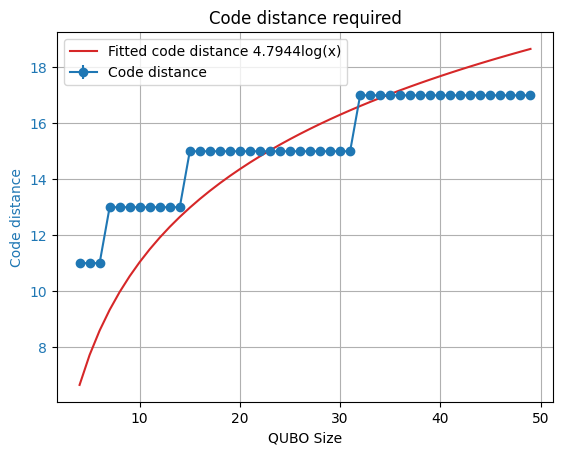

In [23]:
from scipy.optimize import curve_fit
def polynomial_model(x, a):
    return a * np.log(x)


# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(polynomial_model, list(sizes), mean_distances)
a = popt[0]
b=2
# Generate fitted data for the polynomial model
sizes_fit = list(range(4, 50))
fitted_distances = polynomial_model(np.array(sizes_fit), a)

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Code distance', color=color)
ax1.errorbar(sizes, mean_distances, yerr=std_distances, fmt='-o', color=color, label='Code distance')
ax1.plot(sizes_fit, fitted_distances, color='tab:red', label=f'Fitted code distance {round(a,4)}log(x)')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
plt.legend()

# fig.tight_layout()
plt.title('Code distance required')
# plt.tight_layout()
plt.grid()
plt.savefig('fit_distance.pdf')
plt.show()

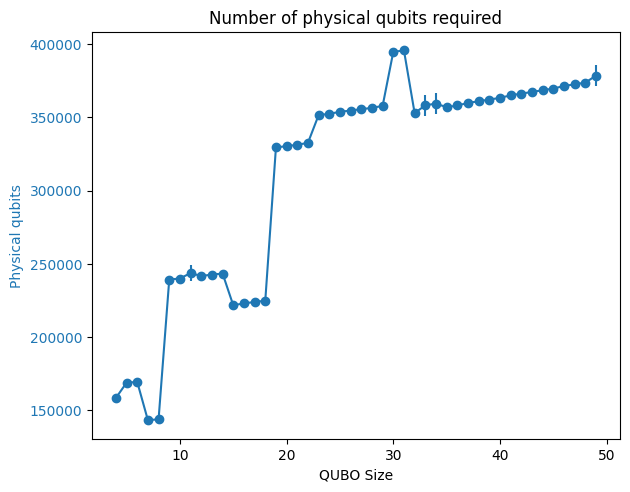

In [ ]:
# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Physical qubits', color=color)
ax1.errorbar(sizes, mean_qubits, yerr=std_qubits, fmt='-o', color=color, label='Physical qubits')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')

fig.tight_layout()
plt.title('Number of physical qubits required')
plt.show()